Gene Ontology aided Compound Protein Binding
Affinity Prediction Using Neural Network

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Input # type: ignore
from tensorflow.keras.layers import BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore
from keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import precision_recall_curve, auc

Loading data

In [2]:
df_davis = pd.read_csv("davis-filter.txt", header=None, sep=" ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])
df_kiba = pd.read_csv("kiba.txt", header=None,sep = " ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])

In [3]:

#check for any missing values in train data
print(df_davis.isnull().any().sum())
#check for any missing values in train data
print(df_kiba.isnull().any().sum())

0
0


Merging the datasets

In [4]:
df = df_kiba
df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score
0,CHEMBL1087421,O00141,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.10000
1,CHEMBL1087421,O14920,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.10000
2,CHEMBL1087421,O15111,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.10000
3,CHEMBL1087421,P00533,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.10000
4,CHEMBL1087421,P04626,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.10000
...,...,...,...,...,...
118249,CHEMBL230654,Q13554,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,10.49794
118250,CHEMBL230654,Q13555,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,10.49794
118251,CHEMBL230654,Q13557,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,10.49794
118252,CHEMBL230654,Q16539,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,10.49794


Using One-Hot encoding for SMILES and AMINO ACIDS sequence

In [5]:
#for amino acid sequence
# Step 1: Extract unique characters from the specified column ('amino_acid_seq')
unique_chars = sorted(set(''.join(df['amino_acid_seq'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['amino_acid_seq_encoded'] = df['amino_acid_seq'].apply(encode_sequence)

#for SMILES sequence
# Step 1: Extract unique characters from the specified column ('SMILES_seq_drug')
unique_chars = sorted(set(''.join(df['SMILES_seq_drug'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['SMILES_seq_drug_encoded'] = df['SMILES_seq_drug'].apply(encode_sequence)


Padding the amino acid and smiles sequences with 0's to ensure uniformity

In [6]:
# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['amino_acid_seq_encoded'], padding='post', value=0)

# Step 2: Assign the padded sequences back to the DataFrame
df['aa_seq_padded'] = list(padded_seqs)

# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['SMILES_seq_drug_encoded'], padding='post', value=0)

# Step 2: Assign the padded sequences back to the DataFrame
df['smiles_seq_padded'] = list(padded_seqs)

#join the padded sequences
df['drug_protein_encoded'] = df.apply(lambda row: np.concatenate([row['aa_seq_padded'], row['smiles_seq_padded']]), axis = 1)

df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score,amino_acid_seq_encoded,SMILES_seq_drug_encoded,aa_seq_padded,smiles_seq_padded,drug_protein_encoded
0,CHEMBL1087421,O00141,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.10000,"[11, 17, 18, 9, 17, 4, 1, 1, 9, 6, 17, 10, 17,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 17, 18, 9, 17, 4, 1, 1, 9, 6, 17, 10, 17,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 17, 18, 9, 17, 4, 1, 1, 9, 6, 17, 10, 17,..."
1,CHEMBL1087421,O14920,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.10000,"[11, 16, 19, 16, 13, 16, 10, 17, 17, 14, 17, 2...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 16, 19, 16, 13, 16, 10, 17, 17, 14, 17, 2...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 16, 19, 16, 13, 16, 10, 17, 17, 14, 17, 2..."
2,CHEMBL1087421,O15111,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.10000,"[11, 4, 15, 13, 13, 6, 10, 15, 13, 6, 1, 6, 6,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 15, 13, 13, 6, 10, 15, 13, 6, 1, 6, 6,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 15, 13, 13, 6, 10, 15, 13, 6, 1, 6, 6,..."
3,CHEMBL1087421,P00533,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.10000,"[11, 15, 13, 16, 6, 17, 1, 6, 1, 1, 10, 10, 1,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 15, 13, 16, 6, 17, 1, 6, 1, 1, 10, 10, 1,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 15, 13, 16, 6, 17, 1, 6, 1, 1, 10, 10, 1,..."
4,CHEMBL1087421,P04626,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.10000,"[11, 4, 10, 1, 1, 10, 2, 15, 19, 6, 10, 10, 10...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 10, 1, 1, 10, 2, 15, 19, 6, 10, 10, 10...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 10, 1, 1, 10, 2, 15, 19, 6, 10, 10, 10..."
...,...,...,...,...,...,...,...,...,...,...
118249,CHEMBL230654,Q13554,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,10.49794,"[11, 1, 17, 17, 18, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 18, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 18, 17, 2, 17, 15, 5, 17, 3, 4..."
118250,CHEMBL230654,Q13555,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,10.49794,"[11, 1, 17, 17, 1, 17, 2, 17, 15, 5, 17, 3, 3,...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 1, 17, 2, 17, 15, 5, 17, 3, 3,...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 1, 17, 2, 17, 15, 5, 17, 3, 3,..."
118251,CHEMBL230654,Q13557,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,10.49794,"[11, 1, 16, 17, 17, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 16, 17, 17, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 16, 17, 17, 17, 2, 17, 15, 5, 17, 3, 4..."
118252,CHEMBL230654,Q16539,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,10.49794,"[11, 16, 14, 4, 15, 13, 17, 5, 20, 15, 14, 4, ...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 16, 14, 4, 15, 13, 17, 5, 20, 15, 14, 4, ...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 16, 14, 4, 15, 13, 17, 5, 20, 15, 14, 4, ..."


Train-test splitting – Case 1
Proteins in test set are already seen in the train set


In [7]:

# Define the split function for each protein
def split_protein_data(group):
    # Number of interactions per protein
    n = len(group)

    # Determine how many interactions to include in training (70%)
    train_size = int(0.7 * n)
    
    # Randomly shuffle and split the data
    train_group = group.sample(train_size, random_state=42)
    test_group = group.drop(train_group.index)
    
    return train_group, test_group

# Apply the splitting function to each protein group
train_list = []
test_list = []

for protein, group in df.groupby('protein_id'):
    n = len(group)
    if(n==1): continue
    train_group, test_group = split_protein_data(group)
    train_list.append(train_group)
    test_list.append(test_group)

# Concatenate the training and test sets
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Shuffle the final train and test data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


Checking whether the split happened properly

In [8]:
column_values_1 = set(sorted(train_df['protein_id'].tolist()))
column_values_2 = set(sorted(test_df['protein_id'].tolist()))

print(column_values_1 == column_values_2)

True


Building the Neural Network

In [9]:
model = Sequential()

model.add(Input(shape=(4718,)))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='linear'))

Compiling the model

In [10]:
#Optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999 )

#Compiling the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     4,832,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,117,601 (19.52 MB)

 Trainable params: 5,114,881 (19.51 MB)

 Non-trainable params: 2,720 (10.62 KB)

Training the model

In [11]:
x_train = train_df['drug_protein_encoded']
x_train = pad_sequences(x_train, padding='post', dtype='int8')
y_train = train_df['affinity_score']

x_test = test_df['drug_protein_encoded']
x_test = pad_sequences(x_test, padding='post', dtype='int8')
y_test = test_df['affinity_score']

batch_size = 2000
epochs = 20

customLR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001, 
)

history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_test, y_test), verbose=1, callbacks = [customLR])

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 462ms/step - loss: 136.9413 - mae: 11.6492 - val_loss: 135.8065 - val_mae: 11.5688 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 475ms/step - loss: 129.5888 - mae: 11.3549 - val_loss: 118.1997 - val_mae: 10.8249 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 534ms/step - loss: 120.5322 - mae: 10.9505 - val_loss: 105.6390 - val_mae: 10.2421 - learning_rate: 0.0010
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 483ms/step - loss: 109.3299 - mae: 10.4263 - val_loss: 94.9569 - val_mae: 9.7124 - learning_rate: 0.0010
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 480ms/step - loss: 96.5156 - mae: 9.7933 - val_loss: 81.9922 - val_mae: 9.0216 - learning_rate: 0.0010
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 424ms/step - loss: 82.7117 - mae: 9.0607 - val_loss: 71.3479 - val_mae: 8.4132 - learning_rate: 0.0010
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 415ms/step - loss: 68.4781 - mae: 8.2385 - val_loss: 58.3160 - val_mae: 7.

Evaluating the Model

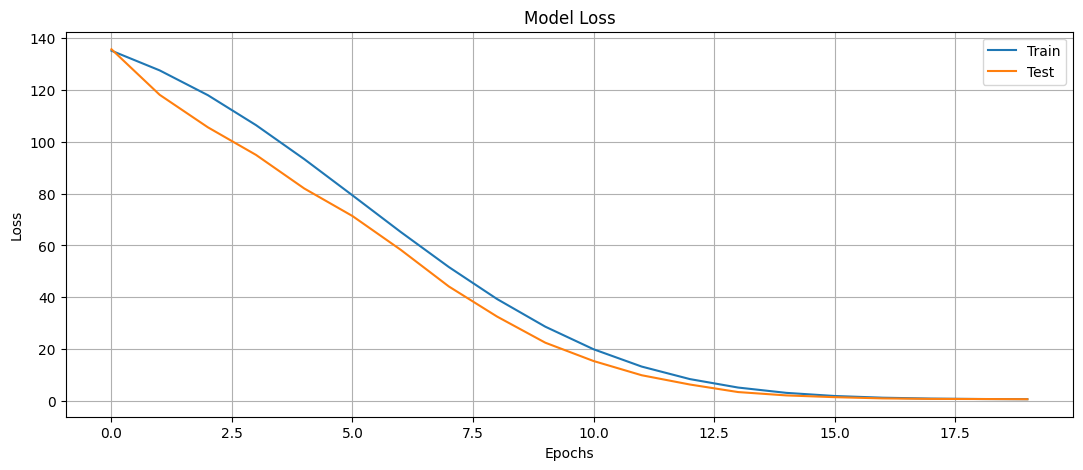

In [12]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

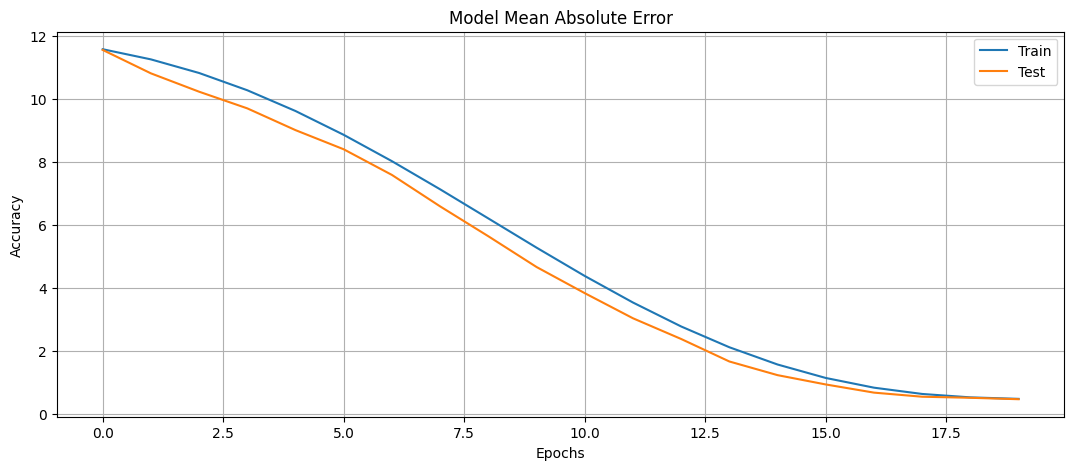

In [13]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

Measuring the performance of model

In [14]:
y_pred = model.predict(x_test).flatten()

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step


In [15]:
# Looking at the predictions
for i in range(len(y_pred)):
    print("actual: ", y_test[i], "predicted: ", y_pred[i])

actual:  11.999998417 predicted:  11.805173
actual:  11.1 predicted:  11.733295
actual:  11.900000875 predicted:  12.00092
actual:  11.500000186 predicted:  11.577296
actual:  11.900000875 predicted:  11.761462
actual:  11.800000504 predicted:  12.288339
actual:  10.1 predicted:  10.746392
actual:  11.200000128 predicted:  11.232736
actual:  12.399997603 predicted:  12.945053
actual:  11.500000186 predicted:  11.481484
actual:  11.400000202 predicted:  11.322604
actual:  11.1 predicted:  11.357023
actual:  11.599999679 predicted:  11.584296
actual:  11.000000142 predicted:  11.35957
actual:  11.500000186 predicted:  11.388923
actual:  11.900000875 predicted:  12.005317
actual:  11.999998417 predicted:  11.907197
actual:  11.1 predicted:  11.345115
actual:  13.1 predicted:  12.065667
actual:  12.499996913 predicted:  13.234714
actual:  11.599999679 predicted:  11.403142
actual:  11.800000504 predicted:  11.504771
actual:  11.900000875 predicted:  12.582161
actual:  12.499996913 predicte

In [16]:

# Calculate the C-Index
ci = concordance_index(y_test, y_pred)
print("concordance index: " , ci)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("mean_squared_error: ", mse)

# Calculate pearson correlation
pearson_corr, p_value = pearsonr(y_test, y_pred)
print("pearson correlation: ", pearson_corr)

concordance index:  0.7108911661116835
mean_squared_error:  0.5656141140677966
pearson correlation:  0.502668380761052
